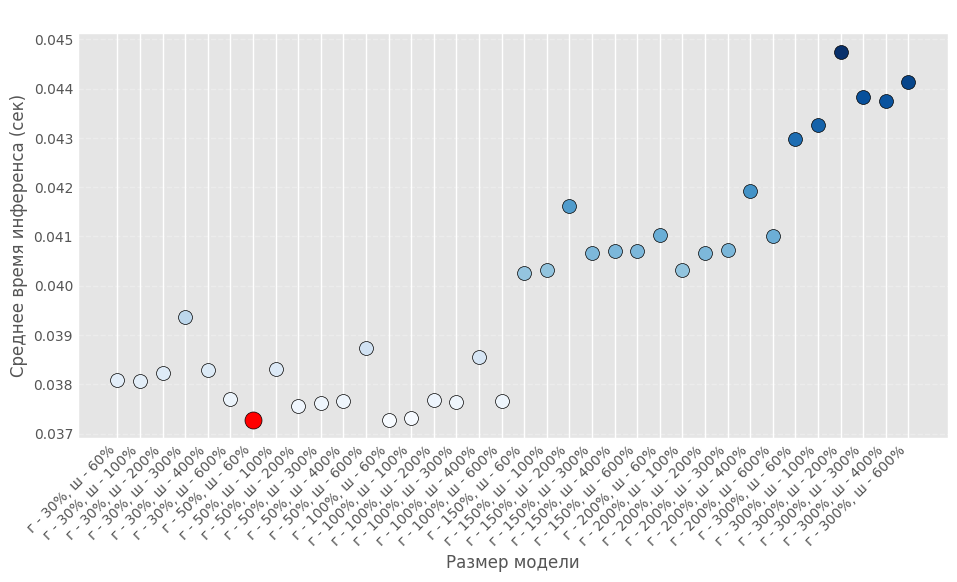

г - 30%, ш - 60%: 0.0381 сек
г - 30%, ш - 100%: 0.0381 сек
г - 30%, ш - 200%: 0.0382 сек
г - 30%, ш - 300%: 0.0394 сек
г - 30%, ш - 400%: 0.0383 сек
г - 30%, ш - 600%: 0.0377 сек
г - 50%, ш - 60%: 0.0373 сек
г - 50%, ш - 100%: 0.0383 сек
г - 50%, ш - 200%: 0.0376 сек
г - 50%, ш - 300%: 0.0376 сек
г - 50%, ш - 400%: 0.0377 сек
г - 50%, ш - 600%: 0.0387 сек
г - 100%, ш - 60%: 0.0373 сек
г - 100%, ш - 100%: 0.0373 сек
г - 100%, ш - 200%: 0.0377 сек
г - 100%, ш - 300%: 0.0376 сек
г - 100%, ш - 400%: 0.0385 сек
г - 100%, ш - 600%: 0.0377 сек
г - 150%, ш - 60%: 0.0403 сек
г - 150%, ш - 100%: 0.0403 сек
г - 150%, ш - 200%: 0.0416 сек
г - 150%, ш - 300%: 0.0407 сек
г - 150%, ш - 400%: 0.0407 сек
г - 150%, ш - 600%: 0.0407 сек
г - 200%, ш - 60%: 0.0410 сек
г - 200%, ш - 100%: 0.0403 сек
г - 200%, ш - 200%: 0.0407 сек
г - 200%, ш - 300%: 0.0407 сек
г - 200%, ш - 400%: 0.0419 сек
г - 200%, ш - 600%: 0.0410 сек
г - 300%, ш - 60%: 0.0430 сек
г - 300%, ш - 100%: 0.0433 сек
г - 300%, ш - 200%: 0.0448

In [121]:
import time
import os
import re
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as T
import numpy as np

# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx] и переводит в формат 'г - n%, ш - k%'"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return None

def measure_inference_time(model_path, image, num_runs=200, mode='yolo'):
    """Измеряет среднее время инференса модели YOLO без учёта первого прогона"""
    if mode == 'yolo':
        model = YOLO(model_path)
        inference_times = []
        
        # Прогоняем инференс num_runs раз
        for i in range(num_runs):
            start_time = time.time()
            _ = model(image, verbose=False)  # Запуск инференса
            end_time = time.time()

            if i > 0:  # Пропускаем первый запуск
                inference_times.append(end_time - start_time)

        return sum(inference_times) / len(inference_times)  # Среднее время инференса

    inference_times = []
    for i in range(num_runs):
        start_time = time.time()
        _ = model_path([image])  # Запуск инференса
        end_time = time.time()

        if i > 0:  # Пропускаем первый запуск
            inference_times.append(end_time - start_time)

    return sum(inference_times) / len(inference_times)

def evaluate_models(logs_dir, image_path, num_runs=200):
    """Проверяет скорость инференса всех моделей в logs_dir и строит график сравнения"""
    to_tensor = T.ToTensor()
    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    image_custom = image.resize((576, 576)) 
    image_custom = to_tensor(image_custom)

    results = {} 
    # Перебираем папки с моделями
    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        model_name = extract_model_size(folder)
        if not model_name:
            continue  # Пропускаем папки без соответствующего формата

        weights_path = os.path.join(folder_path, "weights", "best.pt")
        if os.path.exists(weights_path):
           # Измеряем инференс для модели
            avg_time = measure_inference_time(weights_path, image_path, num_runs)
            results[model_name] = avg_time 

    # Находим модель с минимальным временем инференса
    min_model_name = min(results, key=results.get)
    min_model_time = results[min_model_name]

    # Построение графика
    plt.style.use("ggplot")  # Стиль графика
    plt.figure(figsize=(10, 5))

    # Преобразуем время инференса в список
    inference_times = list(results.values())

    # Нормализуем время инференса для использования в цветовой палитре
    norm_colors = (np.array(inference_times) - min(inference_times)) / (max(inference_times) - min(inference_times))  # Нормализация цвета
    cmap = plt.cm.Blues  # Палитра цветов
    color_map = [cmap(c) for c in norm_colors]  # Применение палитры

    # Построение точек
    for i, (model_name, time) in enumerate(results.items()):
        if model_name == min_model_name:  # Выделяем точку с минимальным временем
            plt.scatter(model_name, time, color='red', s=150, edgecolors='black', zorder=5)
        else:
            plt.scatter(model_name, time, color=color_map[i], s=100, edgecolors='black')

    plt.xlabel("Размер модели")
    plt.ylabel("Среднее время инференса (сек)")
    plt.title("Сравнение скорости инференса YOLO моделей")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle="--", alpha=0.3)

    # Показать результат
    plt.show()

    # Вывод результатов
    for model, time in results.items():
        print(f"{model}: {time:.4f} сек")

# Пути
logs_dir = "../detection/logs/yolo11/"
image_path = "NEWS_110117892_AR_0_RNIEECGWLDXS.webp"

# Запуск
evaluate_models(logs_dir, image_path)


In [100]:
model1 = YOLO('/home/user/master_degree/pits_detection/detection/nets/yolo11.yaml')
model2 = YOLO('/home/user/master_degree/pits_detection/detection/nets/YOLO/yolo11n.yaml')

WARNING ⚠️ no model scale passed. Assuming scale='n'.


In [104]:
sum(p.numel() for p in model1.parameters())

2624080

In [105]:
sum(p.numel() for p in model2.parameters())

20684032

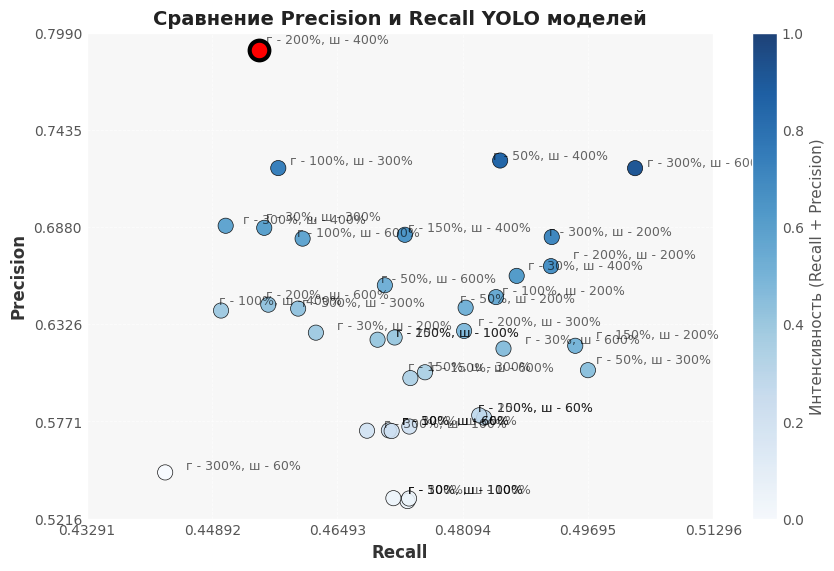

In [122]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """Извлекает depth и width из названия папки в формате [depth_xx-width_xx] и переводит в формат 'г - n%, ш - k%'"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return None

def get_max_metrics(csv_path):
    """Извлекает максимальные Precision и Recall из results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_precision = df["metrics/precision(B)"].max()
        max_recall = df["metrics/recall(B)"].max()
        return max_precision, max_recall
    except Exception as e:
        print(f"Ошибка при обработке {csv_path}: {e}")
        return None, None

def evaluate_models(logs_dir):
    """Собирает Precision и Recall всех моделей и строит улучшенный график"""
    results = {}

    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        model_name = extract_model_size(folder)
        if not model_name:
            continue

        csv_path = os.path.join(folder_path, "results.csv")
        if os.path.exists(csv_path):
            max_precision, max_recall = get_max_metrics(csv_path)
            if max_precision is not None and max_recall is not None:
                results[model_name] = (max_precision, max_recall)

    # Преобразуем данные для градиента цвета
    recalls = np.array([r[1] for r in results.values()])
    precisions = np.array([r[0] for r in results.values()])
    colors = recalls + precisions  # Чем выше recall + precision, тем ярче цвет
    norm_colors = (colors - colors.min()) / (colors.max() - colors.min())  # Нормализация

    # Добавляем jitter (разброс) для избежания наложения точек
    jitter_strength = 0.002
    recalls += np.random.uniform(-jitter_strength, jitter_strength, size=len(recalls))
    precisions += np.random.uniform(-jitter_strength, jitter_strength, size=len(precisions))

    # Стиль графика
    plt.style.use("ggplot")  # Применение стиля seaborn-muted

    fig, ax = plt.subplots(figsize=(9, 6))
    scatter = ax.scatter(recalls, precisions, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

    # Найдем точку с максимальной суммой (precision + recall)
    max_sum_index = np.argmax(precisions + recalls)  # Индекс точки с максимальной суммой
    ax.scatter(recalls[max_sum_index], precisions[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)

    # Добавляем подписи с прозрачностью текста
    for model, (precision, recall) in results.items():
        ax.text(recall + 0.001, precision + 0.001, model, fontsize=9, color = 'black',
                ha="left", va="bottom", alpha=0.6)

    # Динамический масштаб осей
    ax.set_xlim(max(0, min(recalls) - 0.01), min(1.05, max(recalls) + 0.01))
    ax.set_ylim(max(0, min(precisions) - 0.01), min(1.05, max(precisions) + 0.01))

    # Улучшаем стиль осей
    ax.set_xlabel("Recall", fontsize=12, fontweight="bold", color="#333")
    ax.set_ylabel("Precision", fontsize=12, fontweight="bold", color="#333")
    ax.set_title("Сравнение Precision и Recall YOLO моделей", fontsize=14, fontweight="bold", color="#222")

    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 6))
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 6))

    # Улучшенный фон и сетка
    ax.set_facecolor("#F7F7F7")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    # Добавляем цветовую шкалу
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Интенсивность (Recall + Precision)", fontsize=11)

    plt.show()

# Пути
logs_dir = "../detection/logs/yolo11/"

# Запуск
evaluate_models(logs_dir)


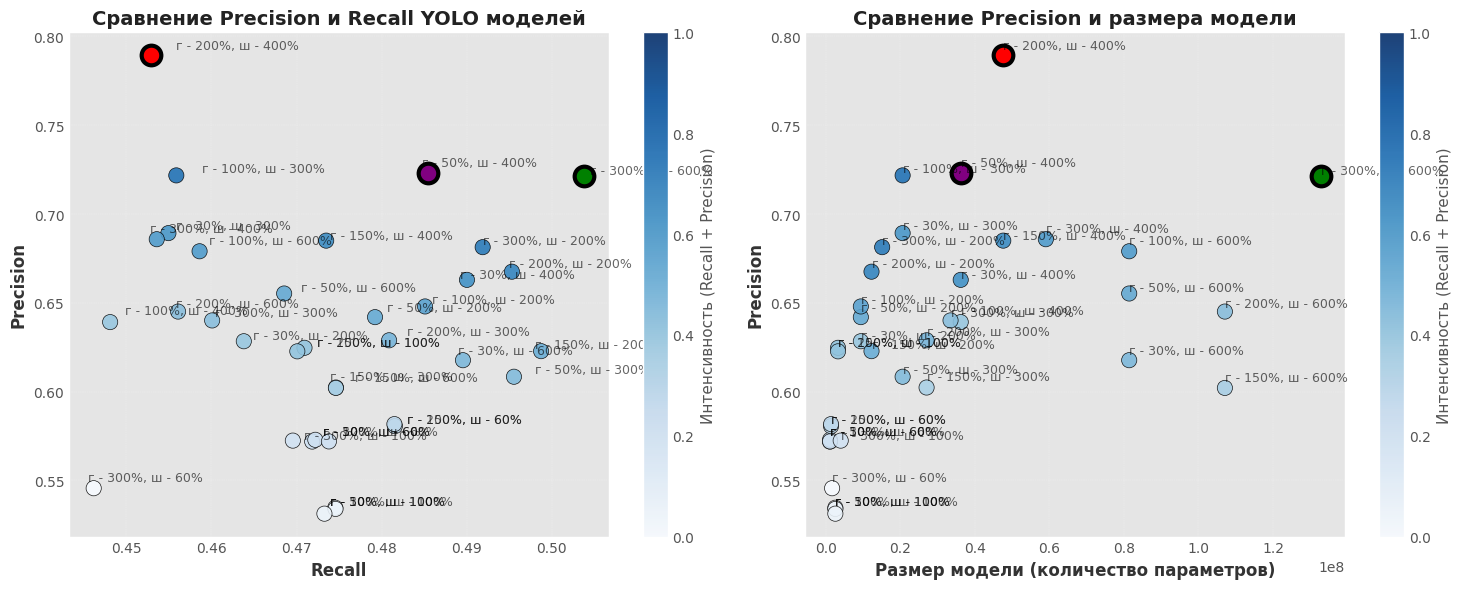

In [127]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from ultralytics import YOLO

# Базовый размер модели YOLO
base_yolo_size = [0.50, 0.25]

def extract_model_size(folder_name):
    """Извлекает параметры depth и width из названия папки в формате [depth_xx-width_xx] и переводит в формат 'г - n%, ш - k%'"""
    match = re.search(r"\[depth_(\d+\.\d+)-width_(\d+\.\d+)\]", folder_name)
    if match:
        depth = float(match.group(1)) * 100
        width = float(match.group(2)) * 100

        # Переводим в проценты относительно базового размера
        depth_percent = (float(match.group(1)) / base_yolo_size[0]) * 100
        width_percent = (float(match.group(2)) / base_yolo_size[1]) * 100

        return f"г - {int(depth_percent)}%, ш - {int(width_percent)}%"
    return None

def get_max_metrics(csv_path):
    """Извлекает максимальные Precision и Recall из results.csv"""
    try:
        df = pd.read_csv(csv_path)
        max_precision = df["metrics/precision(B)"].max()
        max_recall = df["metrics/recall(B)"].max()
        return max_precision, max_recall
    except Exception as e:
        print(f"Ошибка при обработке {csv_path}: {e}")
        return None, None

def get_model_parameters(model_path):
    """Возвращает количество параметров модели YOLO"""
    model = YOLO(model_path)
    params = sum(p.numel() for p in model.parameters())  # Суммируем все параметры модели
    return params

def evaluate_models(logs_dir):
    """Собирает Precision, Recall и количество параметров всех моделей и строит два графика"""
    results = {}

    for folder in sorted(os.listdir(logs_dir)):
        folder_path = os.path.join(logs_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        model_name = extract_model_size(folder)
        if not model_name:
            continue

        csv_path = os.path.join(folder_path, "results.csv")
        if os.path.exists(csv_path):
            max_precision, max_recall = get_max_metrics(csv_path)
            if max_precision is not None and max_recall is not None:
                weights_path = os.path.join(folder_path, "weights", "best.pt")
                num_params = get_model_parameters(weights_path)  # Получаем количество параметров
                results[model_name] = (max_precision, max_recall, num_params)

    # Преобразуем данные для градиента цвета
    recalls = np.array([r[1] for r in results.values()])
    precisions = np.array([r[0] for r in results.values()])
    model_sizes = np.array([r[2] for r in results.values()])

    colors = recalls + precisions  # Чем выше recall + precision, тем ярче цвет
    norm_colors = (colors - colors.min()) / (colors.max() - colors.min())  # Нормализация цвета

    # Добавляем jitter (разброс) для избежания наложения точек
    jitter_strength = 0.002
    recalls += np.random.uniform(-jitter_strength, jitter_strength, size=len(recalls))
    precisions += np.random.uniform(-jitter_strength, jitter_strength, size=len(precisions))

    # Определяем индексы моделей с наибольшими значениями precision + recall
    sorted_indices = np.argsort(precisions + recalls)[::-1]  # Сортируем по убыванию
    max_sum_index = sorted_indices[0]  # 1-е место (красная точка)
    second_sum_index = sorted_indices[1] if len(sorted_indices) > 1 else None  # 2-е место (зеленая точка)
    third_sum_index = sorted_indices[2] if len(sorted_indices) > 2 else None  # 3-е место (фиолетовая точка)

    # Стиль графика
    plt.style.use("ggplot")  # Применение стиля ggplot

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # График Precision vs Recall
    scatter1 = ax1.scatter(recalls, precisions, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

    # Выделяем топ-3 модели
    ax1.scatter(recalls[max_sum_index], precisions[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)
    if second_sum_index is not None:
        ax1.scatter(recalls[second_sum_index], precisions[second_sum_index], c='green', s=200, edgecolors='black', linewidth=3, alpha=1)
    if third_sum_index is not None:
        ax1.scatter(recalls[third_sum_index], precisions[third_sum_index], c='purple', s=200, edgecolors='black', linewidth=3, alpha=1)

    ax1.set_xlabel("Recall", fontsize=12, fontweight="bold", color="#333")
    ax1.set_ylabel("Precision", fontsize=12, fontweight="bold", color="#333")
    ax1.set_title("Сравнение Precision и Recall YOLO моделей", fontsize=14, fontweight="bold", color="#222")
    ax1.grid(True, linestyle="--", linewidth=0.3, alpha=0.5)  # Легкая сетка
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label("Интенсивность (Recall + Precision)", fontsize=11)

    # График Precision vs Model Size (Количество параметров)
    scatter2 = ax2.scatter(model_sizes, precisions, c=norm_colors, cmap="Blues", s=120, edgecolors="black", alpha=0.9)

    # Выделяем топ-3 модели на правом графике
    ax2.scatter(model_sizes[max_sum_index], precisions[max_sum_index], c='red', s=200, edgecolors='black', linewidth=3, alpha=1)
    if second_sum_index is not None:
        ax2.scatter(model_sizes[second_sum_index], precisions[second_sum_index], c='green', s=200, edgecolors='black', linewidth=3, alpha=1)
    if third_sum_index is not None:
        ax2.scatter(model_sizes[third_sum_index], precisions[third_sum_index], c='purple', s=200, edgecolors='black', linewidth=3, alpha=1)

    # Добавляем подписи с прозрачностью текста
    for model, (precision, recall, size) in results.items():
        ax1.text(recall + 0.001, precision + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6)
        ax2.text(size + 0.001, precision + 0.001, model, fontsize=9, color='black', ha="left", va="bottom", alpha=0.6)

    ax2.set_xlabel("Размер модели (количество параметров)", fontsize=12, fontweight="bold", color="#333")
    ax2.set_ylabel("Precision", fontsize=12, fontweight="bold", color="#333")
    ax2.set_title("Сравнение Precision и размера модели", fontsize=14, fontweight="bold", color="#222")
    ax2.grid(True, linestyle="--", linewidth=0.3, alpha=0.5)  # Легкая сетка
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label("Интенсивность (Recall + Precision)", fontsize=11)

    # Добавляем стрелку с подписью на правый график
    ax2.annotate(
        "Больше параметров", 
        xy=(0.8, 0), 
        xytext=(1.1, 0.05), 
        arrowprops=dict(facecolor="black", arrowstyle="->"),
        fontsize=12, 
        color="black"
    )

    plt.tight_layout()
    plt.show()

# Пути
logs_dir = "../detection/logs/yolo11/"

# Запуск
evaluate_models(logs_dir)


In [120]:
def quick_sort(arr):
    # Базовый случай: если массив длиной 1 или пустой, он уже отсортирован
    if len(arr) <= 1:
        return arr
    
    # Выбираем опорный элемент (в данном случае последний элемент)
    pivot = arr[-1]
    
    # Список элементов, меньших опорного
    left = []
    # Список элементов, больших или равных опорному
    right = []
    
    # Перебираем все элементы массива, кроме опорного
    for element in arr[:-1]:
        if element < pivot:
            # Если элемент меньше опорного, добавляем в левый список
            left.append(element)
        else:
            # Если элемент больше или равен опорному, добавляем в правый список
            right.append(element)
    print(left, pivot, right)
    # Рекурсивно сортируем левую и правую часть, затем комбинируем с опорным элементом
    return quick_sort(left) + [pivot] + quick_sort(right)


# Пример использования
arr = [3, 9, 5, 2, 8, 4]
sorted_arr = quick_sort(arr)
print("Отсортированный массив:", sorted_arr)


[3, 2] 4 [9, 5, 8]
[] 2 [3]
[5] 8 [9]
Отсортированный массив: [2, 3, 4, 5, 8, 9]
